# Konwolucyjne sieci neuronowe

Dziś spróbujemy stworzyć i wytrenować prostą sieć konwolucyjną do rozpoznawania, co znajduje się na obrazie. Następnie omówimy kwestię identyfikowania obiektów na obrazie, oraz porozmawiamy o wykorzystaniu gotowej już sieci.

## Problem klasyfikacji obrazów

Jak się za to zabrać? Naiwnym podejściem byłaby próba ręcznej specyfikacji pewnych cech (niemowlęta mają duże głowy, szczoteczki są długie, etc.). Szybko jednak stwierdziliśmy, że nawet dla niewielkiego zbioru kategorii jest to tytaniczna praca bez gwarancji sukcesu. Co więcej, istnieje wiele czynników zniekształcających zawartość naszych zdjęć. Obiekty mogą być przedstawiane z różnych ujęć, w różnych warunkach oświetleniowych, w różnej skali, częściowo niewidoczne, ukryte w tle...

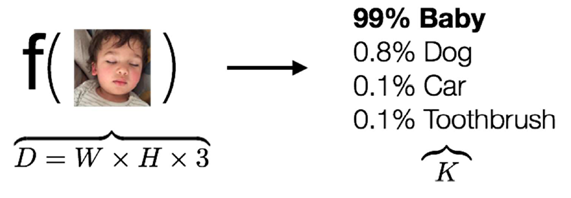


Wszystkie wymienione problemy są skutkiem istnienia semantycznej przepaści między tym, jak reprezentowane są nasze dane wejściowe (tablica liczb), a tym, czego w nich szukamy, czyli kategorii i cech: zwierząt, nosów, głów, itp. Zamiast więc próbować samodzielnie napisać funkcję $f(x)$, spróbujemy skorzystać z dobrodziejstw uczenia maszynowego, aby automatycznie skonstruować reprezentację wejścia właściwą dla postawionego sobie zadania (a przynajmniej lepszą od pierwotnej). I tu z pomocą przychodzą nam konwolucyjne sieci neuronowe. Do tego trzeba zrozumieć, czym jest konwolucja (inaczej: splot), a do tego najlepiej nadają się ilustracje, jak to działa.

### Konwolucja

Konwolucja (splot) to działanie określone dla dwóch funkcji, dające w wyniku inną, która może być postrzegana jako zmodyfikowana wersja oryginalnych funkcji.

Z naszego punktu widzenia polega to na tym, że mnożymy odpowiadające sobie elementy z dwóch macierzy: obrazu, oraz mniejszej, nazywanej filtrem (lub kernelem. Następnie sumujemy wynik i zapisujemy do macierzy wynikowej na odpowiedniej pozycji. Proces powtarza się aż do momentu przeskanowania całego obrazu. Taki filtr wykrywa, czy coś do niego pasuje w danym miejscu, i z tego wynika zdolność semantycznej generalizacji sieci - uczymy się cech, a wykrywamy je potem w dowolnym miejscu. [Przydatne pojęcia](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

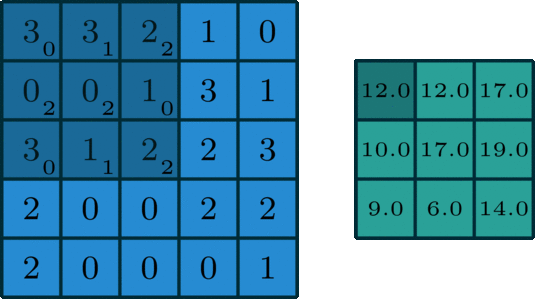

### Stride

Krok algorytmu, albo przesunięcie.


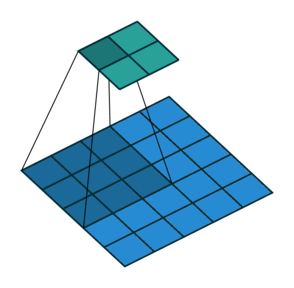



### Padding

Dopełnienie krawędzi obrazu. [więcej](https://www.geeksforgeeks.org/cnn-introduction-to-padding/)

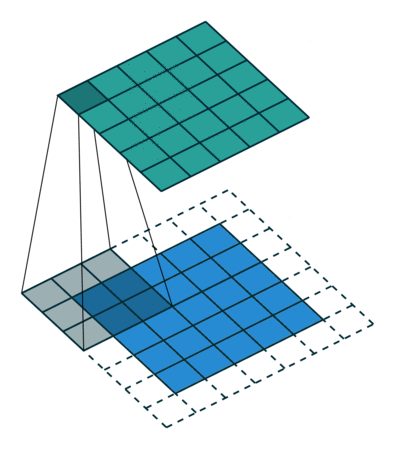

### Pooling

Ma 2 warianty: max oraz avg. Pozwala on usunąć zbędne dane, np. jeżeli filtr wykrywa linie, to istnieje spora szansa, że linie te ciągną się przez sąsiednie piksele, więc nie ma powodu powielać tej informacji. Dzięki temu mamy pewną ilość inwariancji i jesteśmy odporni na niewielkie wahania pikseli, a skupiamy się na "bigger picture".

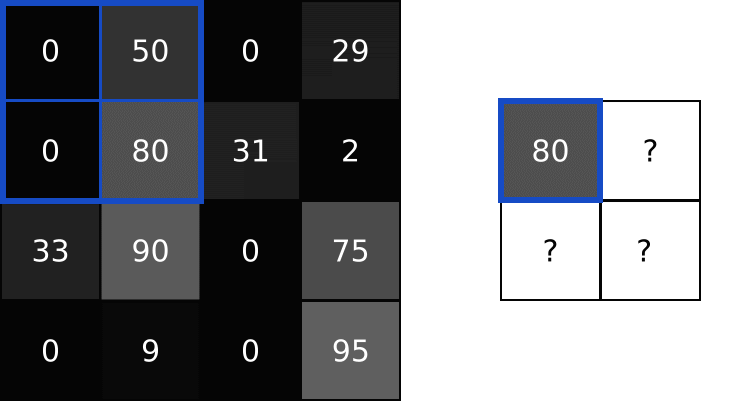

### Sposoby redukcji przeuczenia

* warstwa dropout
* regularyzacja wag
* metoda wczesnego stopu (early stopping)
* batch normalization
* lub... więcej danych

### Budowa sieci CNN do klasyfikacji obrazów

Sieć konwolucyjna składa się zawsze najpierw, zgodnie z nazwą, z części konwolucyjnej, której zadaniem jest wyodrębnienie przydatnych cech z obrazu za pomocą filtrów, warstw poolingowych etc.

W celu klasyfikacji obrazu musimy później użyć sieci MLP. Jako że wejściem do sieci MLP jest zawsze wektor, to musimy obraz przetworzony przez filtry konwolucyjne sprowadzić do takiego wektora, tzw. **embedding**, czyli reprezentacji obrazu jako punktu w pewnej ciągłej przestrzeni. Służą do tego warstwa spłaszczająca (flatten layer), zmieniająca macierze wielkowymiarowe na wektor, np $10 \times 10 \times 3$ na $300 \times 1$.

Część konwolucyjna nazywa się często **backbone**, a część MLP do klasyfikacji **head**. Głowa ma zwykle 1-2 warstwy w pełni połączone, z aktywacją softmax w ostatniej warstwie. Czasem jest nawet po prostu pojedynczą warstwą z softmaxem, bo w dużych sieciach konwolucyjnych ekstrakcja cech jest tak dobra, że taka prosta konstrukcja wystacza do klasyfikacji embeddingu.

In [45]:
import torch
import torchvision
import torchvision.transforms as transforms

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)

testset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True
)

classes = (
    "top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

Zobaczmy, co jest w naszym zbiorze danych. Poniżej kawałek kodu, który wyświetli nam kilka przykładowych obrazków.

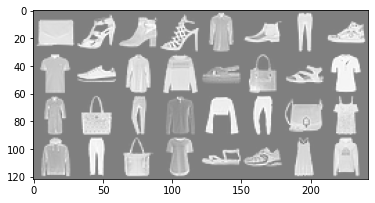

Bag   Sandal Ankle boot Sandal Coat  Ankle boot Trouser Sneaker top   Sneaker Shirt Pullover Sandal Bag   Sandal top   Dress Bag   Trouser Shirt Pullover Trouser Bag   Dress Pullover Trouser Bag   top   Sandal Sneaker Dress Pullover


In [48]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5       
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## LeNet

LeNet to bardzo znany, klasyczny model sieci konwolucyjnej.

Warstwy:
- obraz
- konwolucja, kernel $5 \times 5$, bez paddingu, 6 kanałów (feature maps)
- pooling, kernel $2 \times 2$, stride 2
- konwolucja, kernel $5 \times 5$, bez paddingu, 16 kanałów (feature maps)
- pooling, kernel $2 \times 2$, stride 2
- warstwa w pełni połączona, 120 neuronów na wyjściu
- warstwa w pełni połączona, 84 neurony na wyjściu
- warstwa w pełni połączona, na wyjściu tyle neuronów, ile jest klas

### Zadanie 1 (2 punkty)

Zaimplementuj wyżej opisaną sieć, używając biblioteki PyTorch. Wprowadzimy sobie jednak pewne modyfikacje, żeby było ciekawiej:
- w pierwszej warstwie konwolucyjnej użyj 20 kanałów (feature maps)
- w drugiej warstwie konwolucyjnej użyj 50 kanałów (feature maps)
- w pierwszej warstwie gęstej użyj 300 neuronów
- w drugiej warstwie gęstej użyj 100 neuronów

Przydatne elementy z pakietu `torch.nn`:
* `Conv2d()`
* `AvgPool2d()`
* `Linear()`

Z pakietu `torch.nn.functional`:
* `relu()`

In [49]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #tu zaincjalizuj kolejne warstwy
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50*4*4, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, len(classes))
        self.pool = nn.AvgPool2d(2, 2)

    def forward(self, x):
        #tu  połącz warstwy w sieć, pamietaj o aktywacji i spłaszczeniu w odpowiednich miejscach
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def predict_proba(self, x):
        return F.softmax(self.forward(x), dim=1).to(device)

    def predict(self, x):
        return self.predict_proba(x).argmax(dim=1).to(device)


net = LeNet()
net.to(device)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Zadanie 2 (1 punkt)

Uzupełnij pętlę uczącą sieć na podstawie jej predykcji. Oblicz (wykonaj krok do przodu) funkcję straty, a następnie przeprowadź propagację wsteczną i wykonaj krok optymalizatora, porównaj czas uczenia na cpu i gpu.

In [51]:
net.train()

for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        # Uzupełnij mnie 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,   200] loss: 2.291
[1,   400] loss: 2.179
[1,   600] loss: 1.390
[1,   800] loss: 1.008
[1,  1000] loss: 0.925
[1,  1200] loss: 0.862
[1,  1400] loss: 0.831
[1,  1600] loss: 0.793
[1,  1800] loss: 0.778
[2,   200] loss: 0.759
[2,   400] loss: 0.754
[2,   600] loss: 0.723
[2,   800] loss: 0.731
[2,  1000] loss: 0.733
[2,  1200] loss: 0.703
[2,  1400] loss: 0.690
[2,  1600] loss: 0.690
[2,  1800] loss: 0.665
[3,   200] loss: 0.645
[3,   400] loss: 0.645
[3,   600] loss: 0.631
[3,   800] loss: 0.629
[3,  1000] loss: 0.620
[3,  1200] loss: 0.632
[3,  1400] loss: 0.615
[3,  1600] loss: 0.584
[3,  1800] loss: 0.581
[4,   200] loss: 0.590
[4,   400] loss: 0.568
[4,   600] loss: 0.564
[4,   800] loss: 0.570
[4,  1000] loss: 0.558
[4,  1200] loss: 0.540
[4,  1400] loss: 0.549
[4,  1600] loss: 0.546
[4,  1800] loss: 0.531
[5,   200] loss: 0.536
[5,   400] loss: 0.522
[5,   600] loss: 0.509
[5,   800] loss: 0.511
[5,  1000] loss: 0.503
[5,  1200] loss: 0.498
[5,  1400] loss: 0.511
[5,  1600] 

Skomentuj wyniki:

* Widać, że w ostatnich krokach błąd się zwiększył, czyli pewnie więcej epok z tymi parametrami nie da nam lepszego wyniku

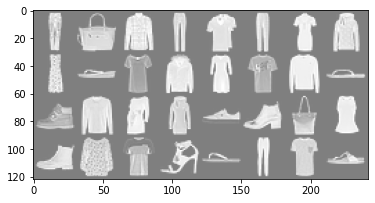

GroundTruth:  Trouser Bag   Shirt Trouser top   Trouser Dress Pullover Dress Sandal Shirt Coat  Dress top   Pullover Sandal Ankle boot Pullover top   Pullover Sneaker Ankle boot Bag   top   Ankle boot Shirt top   Sandal Sandal Trouser top   Sandal


In [52]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [53]:
outputs = net(images.to(device))
# outputs = net(images)

In [54]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(batch_size)))

Predicted:  Trouser Bag   Shirt Trouser top   Trouser Dress Coat  Dress Sandal top   Coat  Dress top   Pullover Sandal Ankle boot Pullover Dress Coat  Sneaker Ankle boot Bag   top   Ankle boot Pullover top   Sandal Sandal Trouser top   Sandal


In [55]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 80 %


### Zadanie 3 (1 punkt)

Oblicz dokładność działania sieci (accuracy) dla każdej klasy z osobna.

In [56]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        #uzupełnij mnie
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: top   is 86.7 %
Accuracy for class: Trouser is 93.9 %
Accuracy for class: Pullover is 72.6 %
Accuracy for class: Dress is 83.4 %
Accuracy for class: Coat  is 75.4 %
Accuracy for class: Sandal is 96.3 %
Accuracy for class: Shirt is 24.3 %
Accuracy for class: Sneaker is 84.6 %
Accuracy for class: Bag   is 95.7 %
Accuracy for class: Ankle boot is 93.7 %


Skomentuj wyniki:

*   Dla specyficznych klas accuracy może być bardzo duże, a dla innych mało. Być może zbiór danych był zbyt mały, lub za krótko trenowany.

## Detekcja obiektów

Jest to problem odmienny od klasyfikacji obrazów, choć w praktyce ściśle z nim powiązany - modele do detekcji obiektów przeważnie do pewnego momentu wyglądają tak samo, jak modele klasyfikacji. Jednak pod koniec sieć jest dzielona na 2 wyjścia: jedno to standardowa klasyfikacja, a drugie to regresor określający pozycję obiektu na obrazie, tzw. bounding box. Najpopularniejszymi przykładami takich sieci są YOLO i Mask R-CNN. Zbiór danych też jest odpowiednio przygotowany do tego zadania i oprócz właściwych zdjęć zawiera również maskę, gdzie tło i każdy istotny obiekt jest zaznaczony innym kolorem.

In [57]:
from torchvision.models import detection
import numpy as np
import cv2
from PIL import Image, ImageDraw
import urllib

Funkcja pozwalająca wczytać obraz z sieci:

In [58]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "street sign",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "hat",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "shoe",
    "eye glasses",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "plate",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "mirror",
    "dining table",
    "window",
    "desk",
    "toilet",
    "door",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "blender",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

colors = np.random.randint(0, 256, size=(len(classes), 3))

In [60]:
models = {
    "frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
    "frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
    "retinanet": detection.retinanet_resnet50_fpn,
}
# load the model and set it to evaluation mode
model = models["frcnn-resnet"](
    weights=detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT,
    progress=True,
    num_classes=len(classes)
).to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

IPython, z którego korzystamy w Jupyter Notebooku, ma wbudowaną funkcję `display()` do wyświetlania obrazów.

In [61]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Toothbrush_x3_20050716_001.jpg/1280px-Toothbrush_x3_20050716_001.jpg --output-document toothbrushes.jpg

--2022-12-28 10:39:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/7a/Toothbrush_x3_20050716_001.jpg/1280px-Toothbrush_x3_20050716_001.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244963 (239K) [image/jpeg]
Saving to: ‘toothbrushes.jpg’

toothbrushes.jpg    100%[===================>] 239.22K  --.-KB/s    in 0.1s    

2022-12-28 10:39:40 (1.66 MB/s) - ‘toothbrushes.jpg’ saved [244963/244963]



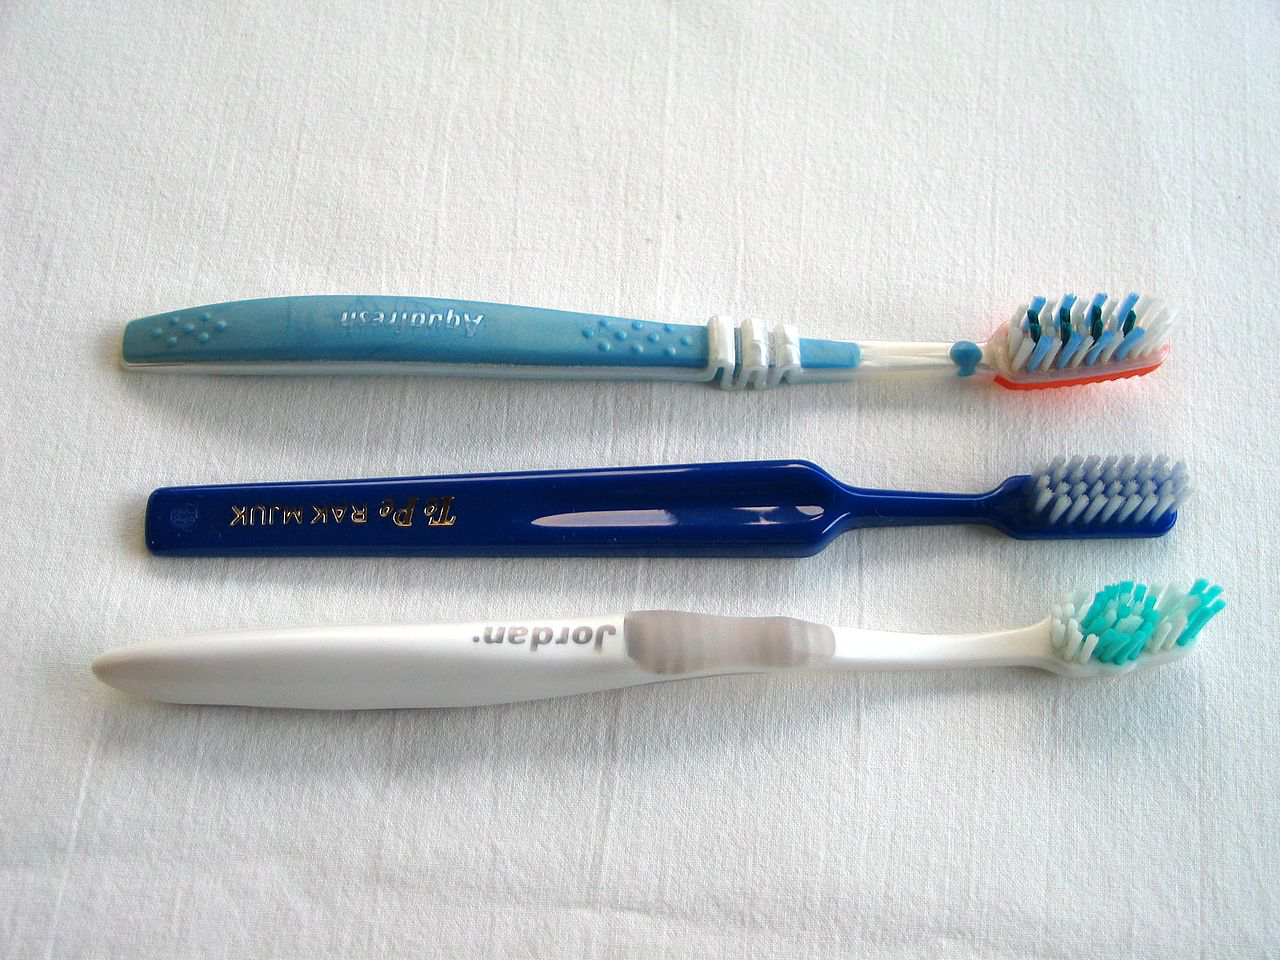

In [62]:
image = Image.open("toothbrushes.jpg")

# make sure we have 3-channel RGB, e.g. without transparency
image = image.convert("RGB")

display(image)

PyTorch wymaga obrazów w kształcie [channels, height, width] (C, H, W) oraz z wartościami pikseli między 0 a 1. Pillow wczytuje obrazy z kanałami (H, W, C) oraz z wartościami pikseli między 0 a 255. Przed wykorzystaniem sieci neuronowej trzeba zatem:
- zamienić obraz na tensor
- zmienić kolejność kanałów
- podzielić wartości pikseli przez 255

In [63]:
image_tensor = torch.from_numpy(np.array(image))
image_tensor = image_tensor.permute(2, 0, 1)
image_tensor_int = image_tensor  # useful for displaying, dtype = uint8
image_tensor = image_tensor / 255
image_tensor.shape, image_tensor.dtype

(torch.Size([3, 960, 1280]), torch.float32)

### Zadanie 4 (1 punkt)

Użyj modelu do wykrycia obiektów na obrazie. Następnie wybierz tylko te bounding boxy, dla których mamy wynik powyżej 50%. Narysuj te bounding boxy, ich prawdopodobieństwa (w procentach) oraz nazwy klas.

Następnie wykorzystaj wyniki do zaznaczenia bounding box'a dla każdego wykrytego obiektu na obrazie oraz podpisz wykrytą klasę wraz z prawdopodobieństwem. Możesz tutaj użyć:
- [OpenCV](https://stackoverflow.com/questions/56108183/python-opencv-cv2-drawing-rectangle-with-text)
- [PyTorch - Torchvision](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#visualizing-bounding-boxes)

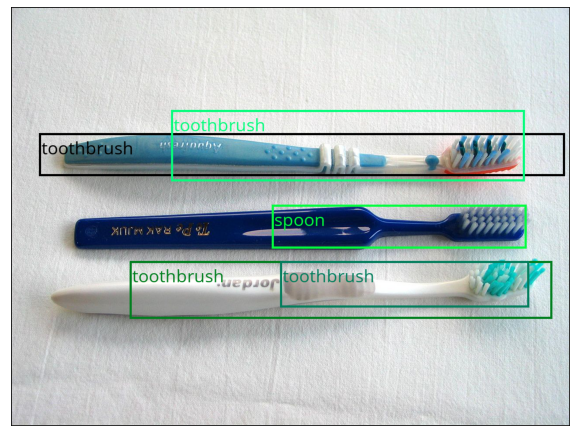

In [64]:
# print(type(image))
# print(type(image_tensor))
# print(image_tensor.shape)

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

with torch.no_grad():
    predictions = model([image_tensor.to(device)])
    threshold = 0.5

    boxes = draw_bounding_boxes(
        image_tensor_int,
        predictions[0]['boxes'][predictions[0]['scores'] > threshold],
        labels=[classes[i] for i in predictions[0]['labels'][predictions[0]['scores'] > threshold]],
        width=5,
        font_size=40,
        font='somefont.ttf'
    )
    # print(predictions)
    # print(boxes)
    show(boxes)

    
    #uzupełnij mnie

## Fine-tuning i pretrening

Jest to jedna z opcji transfer learningu. Mamy w nim już wytrenowaną sieć na dużym zbiorze danych (pretrening) i chcemy, żeby sieć poradziła sobie z nową klasą obiektów (klasyfikacja), albo lepiej radziła sobie z wybranymi obiektami, które już zna (fine-tuning). Możemy usunąć ostatnią warstwę sieci i na jej miejsce wstawić nową, identyczną, jednak z losowo zainicjalizowanymi wagami, a następnie dotrenować sieć na naszym nowym, bardziej specyficznym zbiorze danych. Przykładowo, jako bazę weźmiemy model wytrenowany na zbiorze ImageNet i będziemy chcieli użyć go do rozpoznawania nowych, nieznanych mu klas, np. ras psów.

Dla przykładu wykorzystamy zbiór danych z hotdogami. Będziemy chcieli stwierdzić, czy na obrazku jest hotdog, czy nie. Jako sieci użyjemy modelu ResNet-18, pretrenowanej na zbiorze ImageNet.

In [65]:
!wget http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip

--2022-12-28 10:41:44--  http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 13.249.142.137
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|13.249.142.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261292301 (249M) [application/zip]
Saving to: ‘hotdog.zip.1’

hotdog.zip.1        100%[===================>] 249.19M  44.0MB/s    in 5.7s    

2022-12-28 10:41:50 (43.3 MB/s) - ‘hotdog.zip.1’ saved [261292301/261292301]



In [66]:
!unzip -n hotdog.zip

Archive:  hotdog.zip


In [67]:
import os
import torch
import torch.nn as nn
import torchvision

Kiedy korzystamy z sieci pretrenowanej na zbiorze ImageNet, zgodnie [z dokumentacją](https://pytorch.org/vision/0.8/models.html) trzeba dokonać standaryzacji naszych obrazów, odejmując średnią i dzieląc przez odchylenie standardowe każdego kanału ze zbioru ImageNet.

```
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are
expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229,
0.224, 0.225]. You can use the following transform to normalize:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

```

In [68]:
torch.manual_seed(17)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

test_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

In [69]:
pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [70]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

### Zadanie 5 (1 punkt)

Dodaj warstwę liniową do naszej fine-fune'owanej sieci oraz zainicjuj ją losowymi wartościami.

In [71]:
finetuned_net = pretrained_net

finetuned_net.fc = nn.Sequential(
    nn.Linear(512, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000)
)
#uzupełnij mnie

In [72]:
import time
import copy


def train_model(
    model, dataloaders, criterion, optimizer, num_epochs=25
):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [73]:
data_dir = "hotdog"
batch_size = 32

model_ft = finetuned_net.to(device)
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "train"), transform=train_augs
    ),
    batch_size=batch_size,
    shuffle=True,
)
test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "test"), transform=test_augs
    ),
    shuffle=True,
    batch_size=batch_size,
)
loss = nn.CrossEntropyLoss(reduction="none")

### Zadanie 6 (1 punkt)

Zmodyfikuj tak parametry sieci, aby learning rate dla ostatniej warstwy był 10 razy wyższy niż dla pozostałych.

Trzeba odpowiednio podać pierwszy parametr `torch.optim.SGD` tak, aby zawierał parametry normalne, oraz te z `lr * 10`. Paramety warstw niższych to takie, które mają nazwę inną niż `fc.weight` albo `fc.bias` - może się przydać metoda sieci `named_parameters()`.

In [76]:
def train_fine_tuning(net, learning_rate, num_epochs=15):
    params = [{'params': [param for name, param in net.named_parameters() if 'fc' not in name]}, 
        {'params': net.fc.parameters(), 'lr': 10 * learning_rate}]

    trainer = torch.optim.SGD(params,
                              lr=learning_rate,
                              weight_decay=0.001)#popraw mnie
    dataloaders_dict = {"train": train_iter, "val": test_iter}
    criterion = nn.CrossEntropyLoss()
    model_ft, hist = train_model(
        net, dataloaders_dict, criterion, trainer, num_epochs=num_epochs
    )
    return model_ft, hist

In [77]:
model_ft, hist = train_fine_tuning(model_ft, learning_rate=5e-5)

Epoch 1/15
----------
train Loss: 5.4948 Acc: 0.3610
val Loss: 3.6683 Acc: 0.5388

Epoch 2/15
----------
train Loss: 2.2821 Acc: 0.6065
val Loss: 1.1264 Acc: 0.6975

Epoch 3/15
----------
train Loss: 0.9937 Acc: 0.7585
val Loss: 0.7645 Acc: 0.7950

Epoch 4/15
----------
train Loss: 0.7600 Acc: 0.7945
val Loss: 0.6521 Acc: 0.8438

Epoch 5/15
----------
train Loss: 0.6542 Acc: 0.8335
val Loss: 0.5919 Acc: 0.8463

Epoch 6/15
----------
train Loss: 0.6035 Acc: 0.8485
val Loss: 0.5498 Acc: 0.8725

Epoch 7/15
----------
train Loss: 0.5598 Acc: 0.8565
val Loss: 0.5030 Acc: 0.8800

Epoch 8/15
----------
train Loss: 0.5284 Acc: 0.8715
val Loss: 0.4825 Acc: 0.8812

Epoch 9/15
----------
train Loss: 0.4985 Acc: 0.8700
val Loss: 0.4676 Acc: 0.8862

Epoch 10/15
----------
train Loss: 0.4688 Acc: 0.8765
val Loss: 0.4374 Acc: 0.8775

Epoch 11/15
----------
train Loss: 0.4571 Acc: 0.8695
val Loss: 0.4144 Acc: 0.8862

Epoch 12/15
----------
train Loss: 0.4345 Acc: 0.8910
val Loss: 0.3919 Acc: 0.8862

E

skomentuj wyniki:

*   Accuracy z losowej dość szybko zmieniło są na porządną wartość, blisko 90%, dzięki zastosowaniu pretrenowanej sieci

Przy wyświetlaniu predykcji sieci musimy wykonać operacje odwrotne niż te, które wykonaliśmy, przygotowując obrazy do treningu:
- zamienić kolejność kanałów z (C, H, W) na (H, W, C)
- zamienić obraz z tensora na tablicę Numpy'a
- odwrócić normalizację (mnożymy przez odchylenie standardowe, dodajemy średnią) i upewnić się, że nie wychodzimy poza zakres [0, 1] (wystarczy proste przycięcie wartości)

In [78]:
def imshow(img, title=None):
    img = img.permute(1, 2, 0).numpy()
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds * img + means
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

In [79]:
import matplotlib.pyplot as plt
plt.ion()  


def visualize_model(model, num_images=6):
    class_names = ["hotdog", "other"]
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_iter):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                imshow(inputs.data[j].cpu())

                if images_so_far == num_images:
                    return


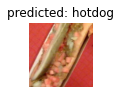

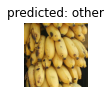

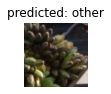

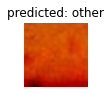

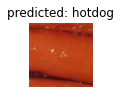

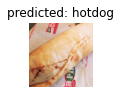

In [80]:
visualize_model(model_ft)

## Rozpoznawanie, kto jest na zdjęciu

In [82]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 


In [83]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision.transforms.functional import to_pil_image

In [84]:
!wget https://raw.githubusercontent.com/timesler/facenet-pytorch/feature/add_vggface2_labels/data/labels-vggface2.csv --output-document vggface_labels.csv

--2022-12-28 11:12:32--  https://raw.githubusercontent.com/timesler/facenet-pytorch/feature/add_vggface2_labels/data/labels-vggface2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139040 (136K) [text/plain]
Saving to: ‘vggface_labels.csv’

vggface_labels.csv  100%[===================>] 135.78K  --.-KB/s    in 0.02s   

2022-12-28 11:12:32 (6.06 MB/s) - ‘vggface_labels.csv’ saved [139040/139040]



## Jak to działa?

Zanim w ogóle pomyślimy o rozpoznawaniu twarzy, najpierw musimy zorientować się, czy w ogóle twarz jest na obrazie, i jeśli tak, to ją wyodrębnić, bo reszta obrazu nas nie interesuje. Ten proces przeważnie znajduje wszystkie twarze na obrazie, nie tylko jedną. Istnieją dwie podstawowe metody znajdowania twarzy na obrazie:
- kaskady Haara - klasyczne podejście, szybkie, w miarę skuteczne, nieodporne na dużę ruchy głowy, okulary itp. (są różne kaskady dla takich przypadków)
- sieci neuronowe, np. MTCNN - bardziej współczesne podejście, są one wolniejsze (a nawet wolne), więc wymagają więcej mocy obliczeniowej, ale za to są skuteczniejsze i bardziej odporne na wszelakie zakłócenia.


Implementacja MTCNN z biblioteki `facenet-pytorch` ma 2 możliwości użycia:
1. Przez metodę `.detect()`, np. `mtcnn.detect(img)`. W ten sposób dostajemy koordynaty (bounding box) twarzy na oryginalnym obrazie. Ma to zastosowanie w samym wykrywaniu twarzy, lub kiedy chcemy później zastosować własne implementacje sieci do rozpoznawania twarzy.
2. Przez metodę `__call__()`, np. `mtcnn(img)`. W ten sposób dostajemy wyciętą i znormalizowaną twarz, gotową do późniejszego użycia w rozpoznawaniu twarzy za pomocą tej biblioteki. Normalizacja to przeskalowanie twarzy tak, żeby miała równe wymiary, oraz standaryzacja kolorów.

Zobaczmy teraz, jak działa pierwsza opcja.

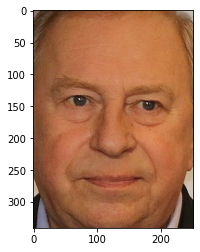

In [85]:
jerzy_stuhr_image_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Jerzy_Stuhr_27_stycznia_2018.jpg/1024px-Jerzy_Stuhr_27_stycznia_2018.jpg"

img = Image.open(urllib.request.urlopen(jerzy_stuhr_image_path)).convert("RGB")

detector = MTCNN(device=device)

boxes, probabilities = detector.detect(img)
box = boxes[0]
face = img.crop(box)

plt.imshow(face)
plt.show()

### Zadanie 7 (1 punkt)

Uzupełnij kod funkcji `extract_face_haar()` tak, by działała tak samo, jak `extract_face_mtcnn()`, ale z wykorzystaniem kaskady Haara z OpenCV. Ma zwracać tensor PyTorcha, abyśmy mogli dalej wykorzystać go do identyfikacji z użyciem sieci neuronowej:
- typu `float32` (OpenCV używa `uint8`)
- z zakresem wartości `[0, 1]` (OpenCV używa `[0, 255]`)
- z kolejnością kanałów `(C, H, W)` (OpenCV, jak Numpy, używa `(H, W, C)`)
- na urządzeniu `device`

Mogą się przydać:
- `cvtColor()`
- `CascadeClassifier()`
- `detectMultiScale()`

W funkcji `extract_face_mtcnn` mamy dodatkowy argument `post_process`. Gdy ma on wartość `False`, to detektor twarzy nie normalizuje obrazu (jedynie zmienia rozmiar na kwadrat) i będzie się wyświetlał "normalnie". Kiedy natomiast chcemy użyć wyjścia z detektora twarzy jako wejścia do drugiej sieci, do identyfikacji osób, to trzeba użyć `post_process=True`, aby użyć odpowiednich transformacji. Typowo daje to lepsze wyniki.

In [87]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-12-28 11:25:01--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2022-12-28 11:25:01 (17.8 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [88]:
def extract_face_mtcnn(image_path, output_face_img_size=160, post_process=False):
    # load image from URL
    img = Image.open(urllib.request.urlopen(image_path)).convert("RGB")
        
    # create the detector
    detector = MTCNN(
        output_face_img_size, 
        device=device,
        post_process=post_process
    )
    # print (type(torch.Tensor(img).to(device)))

    # get face from image
    face = detector(img)
    
    # apply very basic normalization manually when postprocessing is 
    # not used - change values from default [0, 255] to [0, 1]
    if not post_process:
        face /= 255
    
    return face

tensor(0.0118) tensor(0.8706) torch.float32


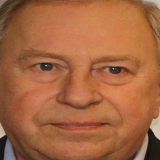

In [89]:
face_mtcnn = extract_face_mtcnn(jerzy_stuhr_image_path)

print(face_mtcnn.min(), face_mtcnn.max(), face_mtcnn.dtype)

# plot the extracted face
to_pil_image(face_mtcnn)

In [125]:
import cv2


def extract_face_haar(filename, required_size=160):
    image = np.array(Image.open(urllib.request.urlopen(filename)))
    # uzupełnij mnie
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    haar = cv2.CascadeClassifier()
    haar.load('haarcascade_frontalface_default.xml')
    boxes = haar.detectMultiScale(gray_image)
    # print(boxes)

    x, y, w, h = boxes[0]
    # print(boxes[0])
    face = image[y:y+h,x:x+h]


    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize((required_size, required_size))
    face_array = np.asarray(image)   
   
    # change channel order from (H, W, C) to (C, H, W)
    face = np.moveaxis(face_array, 2, 0)
    
    # Numpy array -> PyTorch tensor on appropriate device
    face = torch.Tensor(face).to(device)
    
    # convert value range
    face /= 255
    
    return face


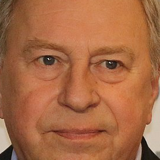

In [126]:
face_haar = extract_face_haar(jerzy_stuhr_image_path)

# plot the extracted face
to_pil_image(face_haar)

Skomentuj wyniki uzyskane przez powyższe metody:

* Metoda korzystająca z kaskad haara jest z pewnością mniej wymagająca obliczeniowo, ale potencjalnie da słabsze efekty. Oba obrazki wydają się podobne.

Skoro udało nam się już znaleźć twarz na obrazku, to spróbujmy rozpoznać, kto się tam znajduje. Znów mamy kilka możliwości, jak to zrobić:
- przygotować sami duży zbiór i nauczyć własną sieć neuronową - zdecydowanie za dużo pracy jak na nasze możliwości na zajęciach
- wykorzystać gotowy dataset - też zbyt czasochłonne, bo uczenie sieci jest bardziej czasochłonne niż jej używanie
- moglibyśmy w ogóle zrezygnować z sieci neuronowej - ale stracilibyśmy na jakości (dokładności) naszego rozwiązania
- wykorzystać przygotowaną już wcześniej sieć

Użyjemy sieci InceptionResnetV1, wytrenowanej na zbiorze twarzy VGGFace2. Jeśli chcesz dowiedzieć się więcej o tej architekturze, to [tutaj](https://iq.opengenus.org/inception-resnet-v1/) znajdziesz jej opis. Przykład użycia pochodzi z [oficjalnego tutoriala](https://github.com/timesler/facenet-pytorch).

In [127]:
identifier = InceptionResnetV1(pretrained="vggface2", classify=True, device=device).eval()

labels = pd.read_csv("vggface_labels.csv", encoding="UTF-8").values.tolist()

In [128]:
from torch.nn.functional import softmax



def get_face_extractor(method, post_process):
    if method == "mtcnn":
        return lambda x: extract_face_mtcnn(x, post_process=post_process)
    elif method == "haar":
        return extract_face_haar
    else:
        raise ValueError(
            f"Method should be either 'mtcnn' or 'haar', got: '{method}'"
        )


def get_top_5_faces(image_path, method="mtcnn", post_process=False):
    detector = get_face_extractor(method, post_process)
    
    with torch.no_grad():
        # extract face
        face = detector(image_path)
        # VGGFace2 classification logits; have to provide batch (4D tensor),
        # so we add "fake" dimension via .unsqueeze()
        logits = identifier(face.to(device).unsqueeze(0)).cpu()

    # we know there is only 1 face, so we can select first (and only) element
    logits = logits[0]

    # get probabilities
    probas = softmax(logits, dim=0)

    # get top 5 predictions
    top_probas, top_indices = torch.topk(probas, k=5)

    top_probas = top_probas.tolist()
    top_indices = top_indices.tolist()
    top_labels = [labels[idx][0] for idx in top_indices]

    for label, proba in zip(top_labels, top_probas):
        label = label.replace("_", " ")
        print(f"{label:<20} {100 * proba:.2f}%")


In [129]:
get_top_5_faces(jerzy_stuhr_image_path, method="haar")
print()
get_top_5_faces(jerzy_stuhr_image_path, method="mtcnn", post_process=False)
print()
get_top_5_faces(jerzy_stuhr_image_path, method="mtcnn", post_process=True)

Jerzy Stuhr          77.41%
Felipe Gonzales      3.31%
Eckart Witzigmann    0.36%
Chelsie Hightower    0.36%
JiÅ™Ã­ LÃ¡bus        0.35%

Jerzy Stuhr          88.59%
Felipe Gonzales      1.18%
Eckart Witzigmann    0.22%
Ilkka Kanerva        0.15%
Marty Markowitz      0.14%

Jerzy Stuhr          83.96%
Felipe Gonzales      0.98%
Eckart Witzigmann    0.27%
Michael Bloomberg    0.22%
Hans Vestberg        0.18%


No fajne, ale co, jeśli chcielibyśmy rozpoznać kogoś, kto nie był częścią pierwotnego zbioru danych? Czy musimy trenować sieć całkowicie od nowa? Oczywiście nie - byłoby to bardzo nieefektywne, bo sieć ta była trenowana na ponad milionie obrazów 8631 ludzi, więc aby dodać jednego, bezsensem byłoby powtarzać cały proces od zera.

Więc jak to zrobić? Można znowu na różne sposoby. Przykładowo, nie ma potrzeby trenować całej sieci, a wystarczy wytrenować ostatnią warstwę, która odpowiada za rozpoznawanie danej osoby. Poprzednie w zasadzie tylko enkodują daną osobę w postaci wektora liczb, tak, aby wektory dla tej samej osoby były blisko sobie, a dla różnych daleko (w sensie pewnej metryki), wieć dla nieznanego obrazu nowej osoby też to zadziała. Musimy jedynie stwierdzić, że to ta sama osoba.

In [130]:
from torchvision.transforms.functional import to_tensor

def get_embeddings(image_paths, method="mtcnn", post_process=False):
    detector = get_face_extractor(method, post_process)
    embedder = InceptionResnetV1(pretrained="vggface2", classify=False, device=device).eval()
    
    embeddings = []
    
    with torch.no_grad():
        for image_path in image_paths:
            face = detector(image_path)
            embedding = embedder(face.to(device).unsqueeze(0)).cpu()
            embedding = embedding.flatten()
            embeddings.append(embedding)
    
    return embeddings


### Zadanie 8 (1 punkt)

Oblicz dystans euklidesowy i cosinusowy między embeddingami. Następnie przetestuj poszczególne metody przygotowanym kodem.

In [149]:
def is_match(known_embedding, candidate_embedding, thresh=0.4, euc_thresh=1.2):
    #uzupełnij mnie`

    print(type(known_embedding*candidate_embedding))
    print('bfa')
    
    cosine_score = 1 - torch.dot(known_embedding,candidate_embedding)/(torch.norm(known_embedding)*torch.norm(candidate_embedding))
    euclidean_score = torch.norm(known_embedding-candidate_embedding)
    
    if cosine_score <= thresh:
        print(">face is a Match - cosine (%.3f <= %.3f)" % (cosine_score, thresh))
        print(">face is a Match - euclidean (%.3f <= %.3f)" % (euclidean_score, euc_thresh))
    else:
        print(">face is NOT a Match - cosine (%.3f > %.3f)" % (cosine_score, thresh))
        print(">face is NOT a Match - euclidean (%.3f > %.3f)" % (euclidean_score, euc_thresh))


In [150]:
def test_person_identification(method, post_process=False):
    # test: Jerzy Stuhr vs new face, Maciej Stuhr
    filenames = [
        "https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Jerzy_Stuhr_27_stycznia_2018.jpg/1024px-Jerzy_Stuhr_27_stycznia_2018.jpg",

        "https://s3.viva.pl/newsy/jerzy-stuhr-276699-GALLERY_600.jpg",
        "https://ocdn.eu/images/pulscms/MjM7MDA_/0d5516ac7244156c40d1366ee008d7e5.jpeg",

        "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/2016_Woodstock_328_Maciej_Stuhr.jpg/800px-2016_Woodstock_328_Maciej_Stuhr.jpg",
        "https://secretum.pl/media/k2/items/cache/7f2cd38b7681e6e2ef83b5a7a5385264_XL.jpg?t=20141001_064823",
    ]

    embeddings = get_embeddings(filenames, method, post_process)

    print("Positive Tests")
    is_match(embeddings[0], embeddings[1])
    is_match(embeddings[0], embeddings[2])
    print()

    print("Negative Tests")
    is_match(embeddings[0], embeddings[3])
    is_match(embeddings[0], embeddings[4])
    print()


In [151]:
test_person_identification(method="haar")
test_person_identification(method="mtcnn", post_process=False)
test_person_identification(method="mtcnn", post_process=True)

Positive Tests
<class 'torch.Tensor'>
bfa
>face is a Match - cosine (0.332 <= 0.400)
>face is a Match - euclidean (0.815 <= 1.200)
<class 'torch.Tensor'>
bfa
>face is a Match - cosine (0.377 <= 0.400)
>face is a Match - euclidean (0.868 <= 1.200)

Negative Tests
<class 'torch.Tensor'>
bfa
>face is NOT a Match - cosine (0.845 > 0.400)
>face is NOT a Match - euclidean (1.300 > 1.200)
<class 'torch.Tensor'>
bfa
>face is NOT a Match - cosine (1.168 > 0.400)
>face is NOT a Match - euclidean (1.528 > 1.200)

Positive Tests
<class 'torch.Tensor'>
bfa
>face is a Match - cosine (0.313 <= 0.400)
>face is a Match - euclidean (0.791 <= 1.200)
<class 'torch.Tensor'>
bfa
>face is a Match - cosine (0.234 <= 0.400)
>face is a Match - euclidean (0.683 <= 1.200)

Negative Tests
<class 'torch.Tensor'>
bfa
>face is NOT a Match - cosine (0.772 > 0.400)
>face is NOT a Match - euclidean (1.242 > 1.200)
<class 'torch.Tensor'>
bfa
>face is NOT a Match - cosine (1.038 > 0.400)
>face is NOT a Match - euclidean (

Skomentuj wyniki:

*   Wyniki są poprawne tj. dla pozytywnych przypadków dają akceptują podobieństwo obiektów, a dla innych odrzucają. Ostatnia metoda daje najlepsze wyniki, bo dla tych samych twarzy daje najmniejsze wyniki metryk, a dla różnych są największe.

## Pytania kontrolne (1 punkt)

1. Jakiego algorytmu użyłbyś do wykrywania obiektów w czasie rzeczywistym?
2. Jaki krok (stride) jest najpowszechniej stosowany i dlaczego?
3. Czy sieci konwolucyjne nadają się do analizy sygnału audio i dlaczego?

1. Kaskad Haara, bo dają stosunkowo dobry wynik przy krótszym czasie przetwarzania danych.
2. Najczęściej dla poolingu spotyka się stride 2, bo często bierze się maski 2x2 (czyli stride takiego rozmiaru jak rozmiar poolingu). W przypadku konwolucji to raczej 1, żeby zachować jak najwięcej danych.
3. Z jednej strony nie, bo audio zależy w dużej mierze samo od siebie i jest szeregiem czasowym. Z drugiej strony mamy twierdzenie o zależności między konwolucją, a DFT, więc jakiś sens może to mieć.

## Zadanie dla chętnych

W zadaniach dotyczących klasyfikacji obrazu wykorzystywaliśmy prosty zbiór danych i sieć LeNet. Teraz zamień zbiór danych na bardziej skomplikowany, np. [ten](http://www.vision.caltech.edu/datasets/cub_200_2011/) lub [ten](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) (lub inny o podobnym poziomie trudności) i zamiast prostej sieci LeNet użyj bardziej złożonej, np. AlexNet, ResNet, MobileNetV2.
